In [3]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)

In [4]:
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [5]:
Smarket = load_data('Smarket')
Smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [6]:
Smarket.corr(numeric_only = True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


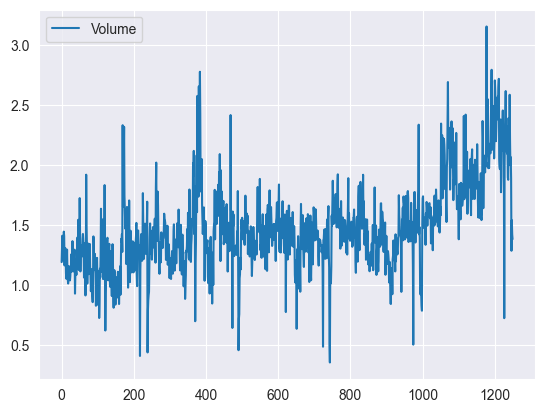

In [7]:
Smarket.plot(y = 'Volume');

In [8]:
allvars = Smarket.columns.drop(['Today', 'Direction', 'Year'])
design = MS(allvars)
X = design.fit_transform(Smarket)
y = Smarket.Direction == 'Up'
glm = sm.GLM(y,
             X,
             family = sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-0.1260,0.241,-0.523,0.601
Lag1,-0.0731,0.050,-1.457,0.145
Lag2,-0.0423,0.050,-0.845,0.398
Lag3,0.0111,0.050,0.222,0.824
Lag4,0.0094,0.050,0.187,0.851
Lag5,0.0103,0.050,0.208,0.835
Volume,0.1354,0.158,0.855,0.392


# Question 1
What can we say about the predictor Volume? Provide three interpretations:

The p-value for Volume is 0.392, which is roughly middle of the pack as far as p-values go among the predictors we used.  The positive coefficient for this predictor suggests that if the the volume goes up then it is more likely to go up today.

Furthermore, e^0.1354 = 1.1450 tells us that the odds of the market going up are 1.1450 times higher for each additional unit of Volume.  Equivalently a one unit increase in Volume is associated with a 14.5% increase in the odds of an 'up' day.

However, with a p-value of 0.392, the p-value is still relatively large, and so there is no clear evidence of a real association between Volume and Direction.

In [9]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [10]:
labels = np.array(['Down'] * 1250)
labels[probs > 0.5] = 'Up'
labels[:10]

array(['Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Down'],
      dtype='<U4')

In [11]:
confusion_table(labels, Smarket.Direction)

Truth,Down,Up
Predicted,,
Down,145,141
Up,457,507


In [12]:
train = (Smarket.Year < 2005)
Smarket_train = Smarket.loc[train]
Smarket_test = Smarket.loc[~train]

In [13]:
X_train, X_test = X.loc[train], X.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.GLM(y_train,
                   X_train,
                   family = sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog = X_test)

In [14]:
D = Smarket.Direction
L_train, L_test = D.loc[train], D.loc[~train]

labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,77,97
Up,34,44


In [16]:
model = MS(['Lag1', 'Lag2']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]

glm_train = sm.GLM(y,
                   X,
                   family = sm.families.Binomial())
results = glm_train.fit()

probs = results.predict(exog = X_test)

labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,9,9
Up,102,132


In [18]:
Smarket_train['Direction'].value_counts()

Direction
Up      507
Down    491
Name: count, dtype: int64

In [19]:
Smarket_test['Direction'].value_counts()

Direction
Up      141
Down    111
Name: count, dtype: int64

In [23]:
confusion_table(labels, L_test)
model = MS(['Lag1', 'Volume']).fit(Smarket)
X = model.transform(Smarket)
X_train, X_test = X.loc[train], X.loc[~train]

glm_train = sm.GLM(y,
                   X,
                   family=sm.families.Binomial())
results = glm_train.fit()

probs = results.predict(exog=X_test)

labels = np.array(['Down'] * 252)
labels[probs > 0.5] = 'Up'
confusion_table(labels, L_test)

Truth,Down,Up
Predicted,,
Down,2,0
Up,109,141


# Question 2
Would a model containing Lag1 and Volume perform better? (The p-value for Volume was roughly the same as the p-value for Lag2) Explain your answer. Make sure to estimate the test error!



In [29]:
HSprog = pd.read_csv('/Users/Camer/Downloads/Spring 2025 Classes/Stat 411/Labs/Datasets/HSprogram')
HSprog.head()

,id,female,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
0,45,yes,low,public,vocational,34,35,41,29,26,no,0,1
1,108,no,middle,public,general,34,33,41,36,36,no,0,1
2,15,no,high,public,vocational,39,39,44,26,42,no,0,1
3,67,no,low,public,vocational,37,37,42,33,32,no,0,1
4,153,no,middle,public,vocational,39,31,40,39,51,no,0,1


In [30]:
X = HSprog[['math', 'read', 'write', 'science']]
y = HSprog['prog']

model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter = 200)
model.fit(X, y)

print(model.coef_)
print(model.intercept_)

[[ 0.07438691  0.03826512  0.0310085  -0.04971534]
 [-0.02531668 -0.01810952 -0.0014197   0.0407125 ]
 [-0.04907023 -0.02015559 -0.0295888   0.00900285]]
[-4.36428265  0.02881579  4.33546686]


C:\Users\Camer\AppData\Local\JetBrains\PyCharm2024.3\demo\PyCharmLearningProject2\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


# Question 3
The second model (comparing vocational to academic program), our Math variable has a coefficient estimate of -0.124.  Provide two interpretations:



In [31]:
y_pred = model.predict_proba(X)
y_pred

array([[0.18807693, 0.1661324 , 0.64579067],
       [0.11598922, 0.20587774, 0.67813305],
       [0.40068438, 0.13257224, 0.46674338],
       [0.20999429, 0.19076489, 0.59924081],
       [0.1028809 , 0.21300754, 0.68411157],
       [0.27748544, 0.16392831, 0.55858625],
       [0.15984277, 0.24288322, 0.59727401],
       [0.23170081, 0.16417654, 0.60412265],
       [0.06573379, 0.25938028, 0.67488593],
       [0.19254173, 0.23916433, 0.56829394],
       [0.1459601 , 0.26280055, 0.59123934],
       [0.05572801, 0.27211151, 0.67216048],
       [0.26266729, 0.1772478 , 0.56008491],
       [0.0993009 , 0.28255176, 0.61814734],
       [0.04743818, 0.31993017, 0.63263165],
       [0.27583164, 0.19867509, 0.52549327],
       [0.11797769, 0.32537472, 0.55664759],
       [0.22655936, 0.22663465, 0.54680598],
       [0.25248856, 0.25879951, 0.48871193],
       [0.1378224 , 0.3057825 , 0.55639511],
       [0.17695305, 0.25645849, 0.56658846],
       [0.26615482, 0.24579514, 0.48805004],
       [0.

In [32]:
y_pred = model.predict(X)
y_pred

array(['vocational', 'vocational', 'vocational', 'vocational',
       'vocational', 'vocational', 'vocational', 'vocational',
       'vocational', 'vocational', 'vocational', 'vocational',
       'vocational', 'vocational', 'vocational', 'vocational',
       'vocational', 'vocational', 'vocational', 'vocational',
       'vocational', 'vocational', 'vocational', 'vocational',
       'vocational', 'vocational', 'academic', 'vocational', 'vocational',
       'vocational', 'vocational', 'vocational', 'vocational', 'academic',
       'vocational', 'vocational', 'vocational', 'academic', 'vocational',
       'vocational', 'vocational', 'academic', 'academic', 'vocational',
       'academic', 'vocational', 'vocational', 'vocational', 'academic',
       'academic', 'vocational', 'vocational', 'vocational', 'academic',
       'vocational', 'vocational', 'academic', 'vocational', 'academic',
       'vocational', 'academic', 'vocational', 'vocational', 'vocational',
       'academic', 'academic',

In [33]:
confusion_table(y, y_pred)

Truth,academic,general,vocational
Predicted,,,
academic,89,3,13
general,25,5,15
vocational,18,6,26


Now lets use cross-validation to estimate the test error. We'll randomly select 150 students to be in the training set.  Train our model using this data.  Then test the model on the 50 students that were held out.